In [181]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Required Libraries:

In [182]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error

In [183]:
# Obtaining stock data of Amazon from Tiigo 
key="fb18ed9a3beb2b0ca2ac9e1c60527427cd2aad06"
df_amzn=pdr.get_data_tiingo("AMZN",api_key=key)
#Top 5 values
df_amzn.head()

close    high       low    open   volume  \
symbol date                                                                   
AMZN   2016-07-25 00:00:00+00:00  739.61  748.50  735.3500  746.55  2679290   
       2016-07-26 00:00:00+00:00  735.59  743.13  732.7525  742.71  2529692   
       2016-07-27 00:00:00+00:00  736.67  740.94  733.8600  737.97  2913134   
       2016-07-28 00:00:00+00:00  752.61  753.36  739.7000  745.98  7617580   
       2016-07-29 00:00:00+00:00  758.81  766.00  755.0000  765.00  6777050   

                                  adjClose  adjHigh    adjLow  adjOpen  \
symbol date                                                              
AMZN   2016-07-25 00:00:00+00:00    739.61   748.50  735.3500   746.55   
       2016-07-26 00:00:00+00:00    735.59   743.13  732.7525   742.71   
       2016-07-27 00:00:00+00:00    736.67   740.94  733.8600   737.97   
       2016-07-28 00:00:00+00:00    752.61   753.36  739.7000   745.98   
       2016-07-29 00:00:00+00:00    758.81   766.00  755.0000   765.00   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AMZN   2016-07-25 00:00:00+00:00    2679290      0.0          1.0  
       2016-07-26 00:00:00+00:00    2529692      0.0          1.0  
       2016-07-27 00:00:00+00:00    2913134      0.0          1.0  
       2016-07-28 00:00:00+00:00    7617580      0.0          1.0  
       2016-07-29 00:00:00+00:00    6777050      0.0          1.0

In [184]:
#Last 5 values 
df_amzn.tail()

close       high        low      open  \
symbol date                                                                 
AMZN   2021-07-15 00:00:00+00:00  3631.20  3695.4000  3620.9200  3694.200   
       2021-07-16 00:00:00+00:00  3573.63  3646.0599  3570.4550  3633.310   
       2021-07-19 00:00:00+00:00  3549.59  3550.2100  3499.1600  3532.580   
       2021-07-20 00:00:00+00:00  3573.19  3592.0000  3518.0000  3567.320   
       2021-07-21 00:00:00+00:00  3585.20  3586.4500  3543.6415  3576.375   

                                   volume  adjClose    adjHigh     adjLow  \
symbol date                                                                 
AMZN   2021-07-15 00:00:00+00:00  3185292   3631.20  3695.4000  3620.9200   
       2021-07-16 00:00:00+00:00  4043706   3573.63  3646.0599  3570.4550   
       2021-07-19 00:00:00+00:00  3784595   3549.59  3550.2100  3499.1600   
       2021-07-20 00:00:00+00:00  3255680   3573.19  3592.0000  3518.0000   
       2021-07-21 00:00:00+00:00  2318989   3585.20  3586.4500  3543.6415   

                                   adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                  
AMZN   2021-07-15 00:00:00+00:00  3694.200    3185292      0.0          1.0  
       2021-07-16 00:00:00+00:00  3633.310    4043706      0.0          1.0  
       2021-07-19 00:00:00+00:00  3532.580    3784595      0.0          1.0  
       2021-07-20 00:00:00+00:00  3567.320    3255680      0.0          1.0  
       2021-07-21 00:00:00+00:00  3576.375    2318989      0.0          1.0

In [185]:
#Using the closing stock prize for Amazon
df_amzn=df_amzn.reset_index()[['date','close']].set_index(['date'])
df_amzn.head()

,close
date,
2016-07-25 00:00:00+00:00,739.61
2016-07-26 00:00:00+00:00,735.59
2016-07-27 00:00:00+00:00,736.67
2016-07-28 00:00:00+00:00,752.61
2016-07-29 00:00:00+00:00,758.81


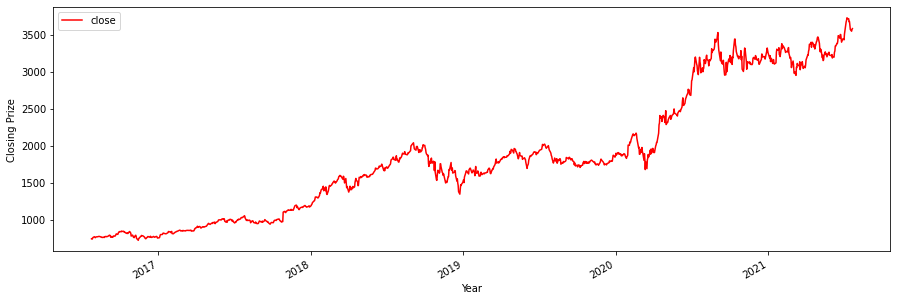

In [186]:
rcParams['figure.figsize']=15,5
df_amzn.plot(color='red')
plt.xlabel('Year')
plt.ylabel('Closing Prize')
plt.show()

#### Over the years the closing prize of stocks on Amazon has seen a gradual increase from 2016 to 2021 as per the plot above.

## Data Scaling:

In [187]:
# Since LSTMs are highly sensitive to the scale of the data, the data is scaled using MinMaxScaler
min_max=MinMaxScaler()
df_amzn_scaled=min_max.fit_transform(np.array(df_amzn['close']).reshape(-1,1))
df_amzn_scaled

array([[0.00681862],
       [0.00548411],
       [0.00584263],
       ...,
       [0.93964161],
       [0.94747605],
       [0.95146298]])

## Splitting the data into Train $ Test:

In [188]:
# The data is split into 70:30 for train and test
train_len=int(len(df_amzn)*0.65)
test_len=len(df_amzn)-train_len

train=df_amzn_scaled[:train_len,:]
test=df_amzn_scaled[train_len:len(df_amzn),:]
print("Train size:",train_len)
print("Test size:",test_len)

Train size: 817
Test size: 440


## Creating the Train and Test Data with certain time_steps:

In [189]:
def create_data(data,time_step):

    X=[]
    y=[]
    for i in range(len(data)-time_step-1):

        # Independent variables will consist of number of values as per the time-stamp for which the Lstm needs to look back on the data
        x_val=df_amzn_scaled[i:(i+time_step),0]
        X.append(x_val)

        # The dependent variable forms the very next value that falls after the time stamp limit
        y_val=df_amzn_scaled[i+time_step,0]
        y.append(y_val)

    return np.array(X),np.array(y)

#Creating the data 
train_X,train_y=create_data(train,150)
test_X,test_y=create_data(test,150)

print("X_train size:",train_X.shape)
print("X_test size:",test_X.shape)
print("y_train size:",train_y.shape)
print("y_test size:",test_y.shape)

X_train size: (666, 150)
X_test size: (289, 150)
y_train size: (666,)
y_test size: (289,)


In [190]:
# Reshaping the X_train and X_test as required by the LSTM model
train_X=train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X=test_X.reshape(test_X.shape[0],test_X.shape[1],1)

## Building a Stacked LSTM model :

In [191]:
# Initialising the model
lstm_model=Sequential()

#1st LSTM layer with input shape 50x1
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))

#2nd LSTM layer
lstm_model.add(LSTM(50,return_sequences=True))

#3rd LSTM layer
lstm_model.add(LSTM(50))

#Output layer 
lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 150, 50)           10400     
_________________________________________________________________
lstm_25 (LSTM)               (None, 150, 50)           20200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Compiling the model:

In [192]:
#Compiling the model with adam optimizer and evaluating using mean squared error as loss
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

## Fitting the model on Train Data:

In [193]:
#Fitting the model on train data and running for 100 epochs
my_model=lstm_model.fit(train_X,train_y,verbose=1,epochs=100,batch_size=32)

Epoch 1/100
21/21 [==============================] - 5s 32ms/step - loss: 0.0283
Epoch 2/100
21/21 [==============================] - 1s 28ms/step - loss: 0.0020
Epoch 3/100
21/21 [==============================] - 1s 24ms/step - loss: 6.2641e-04
Epoch 4/100
21/21 [==============================] - 0s 21ms/step - loss: 5.9147e-04
Epoch 5/100
21/21 [==============================] - 0s 21ms/step - loss: 6.3128e-04
Epoch 6/100
21/21 [==============================] - 0s 21ms/step - loss: 5.3890e-04
Epoch 7/100
21/21 [==============================] - 0s 22ms/step - loss: 5.4695e-04
Epoch 8/100
21/21 [==============================] - 0s 21ms/step - loss: 5.7131e-04
Epoch 9/100
21/21 [==============================] - 0s 21ms/step - loss: 5.2378e-04
Epoch 10/100
21/21 [==============================] - 0s 21ms/step - loss: 5.4449e-04
Epoch 11/100
21/21 [==============================] - 0s 21ms/step - loss: 6.3361e-04
Epoch 12/100
21/21 [==============================] - 0s 21ms/step - lo

## Prediction and Evaluation:

In [194]:
#The model predicts the values for train and test data and inverse transforming the scaled predictions
train_pred=min_max.inverse_transform(lstm_model.predict(train_X))
test_pred=min_max.inverse_transform(lstm_model.predict(test_X))

In [195]:
# Finding the RMSE values for both predictions
train_rmse=mean_squared_error(train_y,train_pred,squared=False)
test_rmse=mean_squared_error(test_y,test_pred,squared=False)
print("The RMSE on train data:",train_rmse)
print("The RMSE on test data:",test_rmse)

The RMSE on train data: 1536.6964987526258
The RMSE on test data: 1139.1837625576907


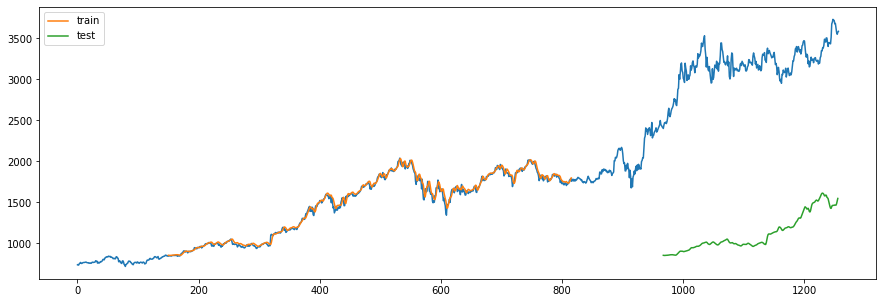

In [198]:

time_stamp=150
plot_train= np.empty_like(df_amzn_scaled)
plot_train[:, :] = np.nan
plot_train[time_stamp:len(train_pred)+time_stamp, :] = train_pred

plot_test = np.empty_like(df_amzn_scaled)
plot_test[:, :] = np.nan
plot_test[len(train_pred)+(time_stamp*2)+1:len(df_amzn_scaled)-1, :] = test_pred

plt.plot(min_max.inverse_transform(df_amzn_scaled))
plt.plot(plot_train,label='train')
plt.plot(plot_test,label='test')
plt.legend()
plt.show()

## Conclusion:

- Extracted Amazon Stocks Data (2016-2021) from Tiingo from which the closing price was used for further analysis.
- Considering a time-stamp of 150 days to look back on, a stacked LSTM model was built on the train data.
- Further predictions were made on test data and evaluated using mean squared error.